Introduçao:

O objetivo desse notebook é avaliar o MSE e o MAE obtido ao calcular-se o T60, utilizando-se do script do T60 blind além das suas medidas parciais para cada subbanda. Esses valores são aplicados a um Regressor do tipo Lasso.

No que se refere à base de dados, os sinais utilizados para teste são os fornecedidos no ACE Challenge - Eval (4.500 áudios, 1500 para cada faixa de SNR  (baixa, media e alta)), já para treinamento são os disponíveis no ACE Challenge - DEV (288 áudios), além dos sinais gerados pela convolução dos sinais anecóicos da base NBP com as RIRs do ACE Challenge, gerando assim a NBP Plus (3600 áudios), totalizando 1200 audios para treino em cada faixa de SNR.

Mais recentemente, foram incorparados ao treinamento 35.515 sinais para alto SNR oriundos da base do REVERB Challenge.

Além disso, acrescentou-se 12.600 sinais para alto SNR obtidos através da convolução de audios anecóicos da base TIMIT com RIRs da base AIR (Universy of York)

Sendo assim, tem-se cerca de 50. 000 sinais de treino e 1.500 de teste.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/jessicsv@poli.ufrj.br\ 2022-05-28\ 18\:49/SMT-reverberacao

/gdrive/MyDrive/jessicsv@poli.ufrj.br 2022-05-28 18:49/SMT-reverberacao


In [3]:
pip install smogn


In [4]:
pip install seaborn

In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import scipy.io
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from numpy import arange
import warnings
from numpy import cov
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import smogn
import pandas as pd
import seaborn as sns
sns.set()

import os
import random
np.random.seed(1)
os.environ['PYTHONHASHSEED'] = str(1)
random.seed(1)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
from time import gmtime, strftime
from datetime import datetime


In [6]:
import sys
sys.path.append('/gdrive/MyDrive/jessicsv@poli.ufrj.br\ 2022-05-28\ 18\:49/SMT-reverberacao')

In [7]:
import dataHandle as dh

#list initialization

In [8]:
lowsnr_label = []
lowsnr_features = []
lowsnr_t60blind_dev = []
mediumsnr_label =[]
mediumsnr_features = []
mediumsnr_t60blind_dev = []
highsnr_label = []
highsnr_features = []
highsnr_t60blind_dev = []
lowsnr_label_test = []
lowsnr_features_test = []
lowsnr_t60blind = []
mediumsnr_label_test =[]
mediumsnr_features_test = []
mediumsnr_t60blind = []
highsnr_label_test = []
highsnr_features_test = []
highsnr_t60blind = []
nbp_md_features_natural = []
nbp_md_t60blindest = []
nbp_label_natural_md = []
nbp_md_features_artificial = []
nbp_md_t60blindest_artificial = []
nbp_label_artificial_md = []
flat_natural = []
flat_ar = []
nbp_md_features_real = []
nbp_md_t60blindest_real = []
nbp_label_real_md = []
flat_real = []
reverb_challenge_md_features = []
reverb_challenge_md_t60blindest = []
reverb_challenge_label_md = []
flat_reverb_challenge = []
flat_blind =[]
flat_blindtest =[]
#University of York data
air_md_features = []
air_md_t60blindest = []
air_label_md = []
flat_air = []

#SNR Class selection

In [9]:
#Seleção da SNR a ser utilizada (0 - baixo SNR, 1 - medio e 2 - alto)
SNR_class=2
number_of_SNR_classes=3

#Loading input data

In [10]:
#loading data ACE
ace_features_dev = dh.loadMatData("Bases_de_dados/ACE_Challenge/T60ACEDevSortedSubBands.mat", "t60p2ACE") # ACE DEV features
ace_features_dev = dh.msToSecond(ace_features_dev) #converting from ms to second

ace_features_eval = dh.loadMatData("Bases_de_dados/ACE_Challenge/T60ACEEvalSortedSubBands.mat","t60p2ACE") #ACE EVAL features
ace_features_eval = dh.msToSecond(ace_features_eval)

ace_label_dev = dh.loadCSVData("Bases_de_dados/ACE_Challenge/GT_dev_ace.csv")  #ACE DEV labels
ace_label_eval = dh.loadCSVData("Bases_de_dados/ACE_Challenge/GT_eval_ACE2.csv") #ACE EVAL labels

ace_dev_snr = dh.loadCSVData("Bases_de_dados/ACE_Challenge/SNR_dev.csv")  #DEV SNR
ace_eval_snr = dh.loadCSVData("Bases_de_dados/ACE_Challenge/SNR_eval_true.csv") #EVAL SNR

#Removing edge values avoiding NaN
ace_features_dev =  dh.removeEdgeValues(ace_features_dev)
ace_features_eval =  dh.removeEdgeValues(ace_features_eval)

#t60blind DEV
t60blind_dev =  dh.loadMatData("Bases_de_dados/ACE_Challenge/t60BlindDev.mat","t60f")
t60blind_dev = dh.msToSecond(t60blind_dev)

#t60blind EVAL
t60blind = dh.loadMatData("Bases_de_dados/ACE_Challenge/t60BlindEval.mat","t60b")
t60blind_float = dh.msToSecond(t60blind.astype(float))


# Spliting features, labels and t60blind for each SNR's on DEV ACE database
for i in range(0,288):
            if ace_dev_snr[i] == 0:
                lowsnr_label.append(ace_label_dev[i])
                lowsnr_features.append(ace_features_dev[i])
                lowsnr_t60blind_dev.append(t60blind_dev[i])

            elif ace_dev_snr[i] == 10:
                mediumsnr_label.append(ace_label_dev[i])
                mediumsnr_features.append(ace_features_dev[i])
                mediumsnr_t60blind_dev.append(t60blind_dev[i])
            elif ace_dev_snr[i] == 20:
                highsnr_label.append(ace_label_dev[i])
                highsnr_features.append(ace_features_dev[i])
                highsnr_t60blind_dev.append(t60blind_dev[i])

## Spliting features, labels and t60blind for each SNR's on EVAL ACE database

for i in range(0,4500):
            if ace_eval_snr[i] == -1 :
                lowsnr_label_test.append(ace_label_eval[i])
                lowsnr_features_test.append(ace_features_eval[i])
                lowsnr_t60blind.append(t60blind_float[i])
            elif ace_eval_snr[i] == 12:
                mediumsnr_label_test.append(ace_label_eval[i])
                mediumsnr_features_test.append(ace_features_eval[i])
                mediumsnr_t60blind.append(t60blind_float[i])
            elif ace_eval_snr[i] == 18:
                highsnr_label_test.append(ace_label_eval[i])
                highsnr_features_test.append(ace_features_eval[i])
                highsnr_t60blind.append(t60blind_float[i])

In [11]:
if SNR_class==0: #lowSNR
  flat_blind   = dh.makeFlat(lowsnr_t60blind_dev)
  selectedsnr_features = dh.joinFeatures(lowsnr_features,flat_blind)
  selectedsnr_label=lowsnr_label
  selectedsnr_features_test =lowsnr_features_test
  selectedsnr_label_test=lowsnr_label_test
  selectedsnr_t60blind=lowsnr_t60blind

elif SNR_class==1: #mediumSNR
  flat_blind   = dh.makeFlat(mediumsnr_t60blind_dev)
  selectedsnr_features = dh.joinFeatures(mediumsnr_features,flat_blind)
  selectedsnr_label=mediumsnr_label
  selectedsnr_features_test =mediumsnr_features_test
  selectedsnr_label_test=mediumsnr_label_test
  selectedsnr_t60blind=mediumsnr_t60blind

else: #highSNR
  flat_blind   = dh.makeFlat(highsnr_t60blind_dev)
  selectedsnr_features = dh.joinFeatures(highsnr_features,flat_blind)
  selectedsnr_label=highsnr_label
  selectedsnr_features_test =highsnr_features_test
  selectedsnr_label_test=highsnr_label_test
  selectedsnr_t60blind=highsnr_t60blind


In [12]:
#Loading NBP plus natural signals
nbp_natural_features = dh.msToSecond(dh.loadMatData("Bases_de_dados/NBP_Plus/SubbandasRIRNaturalSorted.mat","t60p2ACEextraSorted"))
nbp_natural_features = dh.removeEdgeValues(nbp_natural_features)

nbp_natural_t60blind_est = dh.msToSecond(dh.loadMatData("Bases_de_dados/NBP_Plus/T60blindNatural.mat",'t60blindextra'))

#selecting the files which belongs to this SNR class
for i in range(SNR_class,len(nbp_natural_features),number_of_SNR_classes):
            nbp_md_features_natural.append(nbp_natural_features[i])
            nbp_md_t60blindest.append(nbp_natural_t60blind_est[i])

#Leitura do Label do t60 real dos sinais (são iguais para cada SNR)
nbp_label_natural_md = dh.msToSecond(dh.loadCSVData("Bases_de_dados/NBP_Plus/GT_Natural.csv"))

flat_natural= dh.makeFlat(nbp_md_t60blindest)

#Adicionando a feature da predição final do t60blind ao vetor de features
nbp_md_features_natural = dh.joinFeatures(nbp_md_features_natural,flat_natural)

###############################################################################
#  #Loading NBP plus artifical signals
nbp_artificial_features = dh.loadMatData("Bases_de_dados/NBP_Plus/SubbandasRIRartificialSorted.mat","t60p2ACEartSorted")
nbp_artificial_features = dh.msToSecond(dh.removeEdgeValues(nbp_artificial_features))

nbp_artificial_t60blind_est = dh.msToSecond(dh.loadMatData("Bases_de_dados/NBP_Plus/T60blindArtificial.mat",'t60blindart'))

#selecting the files which belongs to this SNR class
for i in range(SNR_class,len(nbp_artificial_features),number_of_SNR_classes):
            nbp_md_features_artificial.append(nbp_artificial_features[i])
            nbp_md_t60blindest_artificial.append(nbp_artificial_t60blind_est[i])

#Leitura do Label do t60 real dos sinais (são iguais para cada SNR)
nbp_label_artificial_md = dh.msToSecond(dh.loadCSVData("Bases_de_dados/NBP_Plus/GT_ARTIFICIAL.csv"))

flat_ar = dh.makeFlat(nbp_md_t60blindest_artificial)

nbp_md_features_artificial = dh.joinFeatures(nbp_md_features_artificial,flat_ar)


#######################################################################################
# Loading NBP plus real (salas) signals
nbp_real_features = dh.msToSecond(dh.loadMatData("Bases_de_dados/NBP_Plus/SubbandasRIRRealSorted.mat","t60p2ACEsalasSorted"))
nbp_real_t60blind_est = dh.msToSecond(dh.loadMatData("Bases_de_dados/NBP_Plus/T60blindReal.mat",'t60blindsalas'))


nbp_real_features = dh.removeEdgeValues(nbp_real_features)

for i in range(SNR_class,len(nbp_real_features),number_of_SNR_classes):
            nbp_md_features_real.append(nbp_real_features[i])
            nbp_md_t60blindest_real.append(nbp_real_t60blind_est[i])

#Leitura do Label do t60 real dos sinais (são iguais para cada SNR)
nbp_label_real_md = dh.msToSecond(dh.loadCSVData("Bases_de_dados/NBP_Plus/GT_Real.csv"))

flat_real = dh.makeFlat(nbp_md_t60blindest_real)

nbp_md_features_real=dh.joinFeatures(nbp_md_features_real,flat_real)

#########################################################################################

In [13]:
### Loading reverb challenge signals # only considered when using highsnr signals

#estimativa parcial do t60
reverb_challenge_features_real_room1 = dh.loadMatData("Bases_de_dados/REVERB_Challenge/RealData_for_8ch_room1ReverbSubBandValues.mat","t60pReverb")
reverb_challenge_features_real_room1 = dh.msToSecond(dh.removeEdgeValues(reverb_challenge_features_real_room1))

reverb_challenge_features_sim_room1 = dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room1ReverbSubBandValues.mat","t60pReverb")
reverb_challenge_features_sim_room1 = dh.msToSecond(dh.removeEdgeValues(reverb_challenge_features_sim_room1))

reverb_challenge_features_sim_room2 = dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room2ReverbSubBandValues.mat","t60pReverb")
reverb_challenge_features_sim_room2 = dh.msToSecond(dh.removeEdgeValues(reverb_challenge_features_sim_room2) )

reverb_challenge_features_sim_room3 = dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room3ReverbSubBandValues.mat","t60pReverb")
reverb_challenge_features_sim_room3 = dh.msToSecond(dh.removeEdgeValues(reverb_challenge_features_sim_room3))

# #estimativa final do t60
reverb_challenge_t60blind_est_real_room1 = dh.msToSecond(dh.loadMatData("Bases_de_dados/REVERB_Challenge/RealData_for_8ch_room1_T60f.mat",'t60fatt'))

reverb_challenge_t60blind_est_sim_room1 = dh.msToSecond(dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room1_T60f.mat",'t60fatt'))

reverb_challenge_t60blind_est_sim_room2 = dh.msToSecond(dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room2_T60f.mat",'t60fatt'))

reverb_challenge_t60blind_est_sim_room3 = dh.msToSecond(dh.loadMatData("Bases_de_dados/REVERB_Challenge/SimData_for_8ch_room3_T60f.mat",'t60fatt'))

# label
train_labels_reverb_challenge = dh.msToSecond(dh.loadCSVData('Bases_de_dados/REVERB_Challenge/GT_reverb_challenge.csv'))

#Incluindo os dados nas listas de features:
for i in range(0,len(reverb_challenge_features_real_room1)):
            reverb_challenge_md_features.append(reverb_challenge_features_real_room1[i])
            reverb_challenge_md_t60blindest.append(reverb_challenge_t60blind_est_real_room1[i])

for i in range(0,len(reverb_challenge_features_sim_room1)):
            reverb_challenge_md_features.append(reverb_challenge_features_sim_room1[i])
            reverb_challenge_md_t60blindest.append(reverb_challenge_t60blind_est_sim_room1[i])

for i in range(0,len(reverb_challenge_features_sim_room2)):
            reverb_challenge_md_features.append(reverb_challenge_features_sim_room2[i])
            reverb_challenge_md_t60blindest.append(reverb_challenge_t60blind_est_sim_room2[i])

for i in range(0,len(reverb_challenge_features_sim_room3)):
            reverb_challenge_md_features.append(reverb_challenge_features_sim_room3[i])
            reverb_challenge_md_t60blindest.append(reverb_challenge_t60blind_est_sim_room3[i])

for i in range(0,len(train_labels_reverb_challenge )):
            reverb_challenge_label_md.append(train_labels_reverb_challenge[i])

flat_reverb_challenge  = dh.makeFlat(reverb_challenge_md_t60blindest)

reverb_challenge_md_features = dh.joinFeatures(reverb_challenge_md_features,flat_reverb_challenge)

In [14]:
 ### Loading air signals only considered when using highsnr signals
#estimativa parcial do t60
air_features_st_margareth = dh.msToSecond(dh.loadMatData("Bases_de_dados/AIR_UniversityOfYork/t60_1200ms_st_margareth.mat","t60p"))

# ordenando e retirando os extremos
air_features_st_margareth = dh.removeEdgeValues(air_features_st_margareth)

#estimativa parcial do t60
air_features_falkland = dh.msToSecond(dh.loadMatData("Bases_de_dados/AIR_UniversityOfYork/t60_1800ms_falkland.mat","t60p"))

# ordenando e retirando os extremos
air_features_falkland = dh.removeEdgeValues(air_features_falkland)

# #estimativa final do t60 # ainda tenho que gerar esses arquivos
air_t60blind_est_st_margareth = dh.msToSecond(dh.loadMatData("Bases_de_dados/AIR_UniversityOfYork/t60blind_1200ms_st_margareth.mat",'t60fatt'))


air_t60blind_est_falkland = dh.msToSecond(dh.loadMatData("Bases_de_dados/AIR_UniversityOfYork/t60blind_1800ms_falkland.mat",'t60fatt'))


# label
train_labels_air_st_margareth = dh.msToSecond(dh.loadCSVData('Bases_de_dados/AIR_UniversityOfYork/GT_air_st_margareth.csv'))
train_labels_air_falkland = dh.msToSecond(dh.loadCSVData('Bases_de_dados/AIR_UniversityOfYork/GT_air_falkland.csv'))

# ajustando as features:
for i in range(0,len(air_features_st_margareth)):
            air_md_features.append(air_features_st_margareth[i])
            air_md_t60blindest.append(air_t60blind_est_st_margareth[i])

for i in range(0,len(air_features_falkland)):
            air_md_features.append(air_features_falkland[i])
            air_md_t60blindest.append(air_t60blind_est_falkland[i])

for i in range(0,len(train_labels_air_st_margareth)):
            air_label_md.append(train_labels_air_st_margareth[i])

for i in range(0,len(train_labels_air_falkland)):
            air_label_md.append(train_labels_air_falkland[i])

flat_air  = dh.makeFlat(air_md_t60blindest)

air_md_features=dh.joinFeatures(air_md_features,flat_air)


###########################################################################################

#Spliting test and trainning data

In [15]:
#Dividindo as diferentes bases de treino para embaralha-las e caso queira se fazer algum tipo de validação, aqui a parte de "test" seria validacao
X_train_ace, X_test_ace, y_train_ace, y_test_ace = train_test_split(selectedsnr_features, selectedsnr_label, test_size=0.25, random_state=0)
X_train_natural, X_test_natural, y_train_natural, y_test_natural = train_test_split(nbp_md_features_natural, nbp_label_natural_md, test_size=0.25, random_state=0)
X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(nbp_md_features_artificial, nbp_label_artificial_md, test_size=0.25, random_state=0)
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(nbp_md_features_real, nbp_label_real_md, test_size=0.25, random_state=0)
X_train_reverb, X_test_reverb, y_train_reverb, y_test_reverb = train_test_split(reverb_challenge_md_features, reverb_challenge_label_md, test_size=0.25, random_state=0)
X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(air_md_features, air_label_md, test_size=0.25, random_state=0)

# #Colocando todos eles em apenas uma variavel para depois treinar #todas as bases
# X_train = np.concatenate((X_train_ace,X_train_natural,X_train_ar, X_train_real,X_train_reverb,X_train_air))
# X_val = np.concatenate((X_test_ace, X_test_natural,X_test_ar, X_test_real,X_test_reverb,X_test_air))
# y_train = np.concatenate((y_train_ace, y_train_natural,y_train_ar, y_train_real,y_train_reverb,y_train_air))
# y_val = np.concatenate((y_test_ace, y_test_natural,y_test_ar, y_test_real,y_test_reverb,y_test_air))


#Colocando todos eles em apenas uma variavel para depois treinar #base ace e air
# X_train = np.concatenate((X_train_ace,X_train_natural,X_train_ar, X_train_real,X_train_air))
# X_val = np.concatenate((X_test_ace, X_test_natural,X_test_ar, X_test_real,X_test_air))
# y_train = np.concatenate((y_train_ace, y_train_natural,y_train_ar, y_train_real,y_train_air))
# y_val = np.concatenate((y_test_ace, y_test_natural,y_test_ar, y_test_real,y_test_air))

#somente a base ace + nbp plus
X_train = np.concatenate((X_train_ace,X_train_natural,X_train_ar, X_train_real))
X_val = np.concatenate((X_test_ace, X_test_natural,X_test_ar, X_test_real))
y_train = np.concatenate((y_train_ace, y_train_natural,y_train_ar, y_train_real))
y_val = np.concatenate((y_test_ace, y_test_natural,y_test_ar, y_test_real))

#somente a base ace
# X_train = X_train_ace
# X_val = X_test_ace
# y_train = y_train_ace
# y_val = y_test_ace



y_train = np.array(y_train)
tamanho = np.arange(len(y_train))

#Aqui os dados são juntados pois não haverá validação e é criado uma dataframe para a smogn
#que recebe apenas panda dataframe como entrada
dados = np.concatenate((X_train,X_val))
df_selected = pd.DataFrame(dados)
train_label_final = np.concatenate((y_train,y_val))
df_selected['labels'] = train_label_final

#Criando uma copia das features de test antes de adicionar o t60 blind como feature e depois adicionando
test_features_eval = selectedsnr_features_test.copy()

flat_blindtest = dh.makeFlat(selectedsnr_t60blind)
selectedsnr_features_test=dh.joinFeatures(selectedsnr_features_test,flat_blindtest)

In [16]:
# antes do smogn
valores_sem_smogn = df_selected.to_numpy()
features_nbp_plus_semT60 = valores_sem_smogn[:,0:509] # Features apenas da DEV e nbp plus sem SMOGN e sem adicionar t60blind
features_nbp_plus= valores_sem_smogn[:,0:510] #incluindo t60
labels_com_nbp_plus = valores_sem_smogn[:,510] #Label dos dados acima

#SMOGN

In [17]:
# # # #Matriz de prioridades para a smogn 0 é alta prioridade e 1 é baixa #walter
rg_mtrx = [[1.16,0,0],
         [0.1,1,0]]

# # # # # # #testando nova matriz
# # # # # # # #Matriz de prioridades para a smogn 1 é alta prioridade e 0 é baixa #jessica
# rg_mtrx = [[1.3,1,0],
#            [0.1,0,0]]


# # # #Usando a função da smogn
selectedsnr_smogn = smogn.smoter(
            data = df_selected,
            y = 'labels', #string name of the data to be predicted
            k = 7,                    ## positive integer (k < n)
            pert = 0.05,              ## real number (0 < R < 1)
            samp_method = 'balance',  ## string ('balance' or 'extreme') # less or more over/under-sampling is conducted.
            drop_na_col = True,       ## boolean (True or False) #whether or not to automatically remove features (columns) that contain missing values
            drop_na_row = True,       ## boolean (True or False) #whether or not to automatically remove observations (rows) that contain missing values
            replace = False,          ## boolean (True or False) #whether or not to utilize replacement in under-sampling (

            ## phi relevance arguments
            rel_thres = 0.2,         ## real number (0 < R < 1)  #It specifies the threshold of rarity. The higher the threshold, the higher the over/under-sampling boundary.
            rel_method = 'manual',    ## string ('auto' or 'manual') # It specifies how relevant or rare "minority" values in y are determined.
            # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
            # rel_coef = 1.50,        ## unused (rel_method = 'manual')
            rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])  It is used to manually specify the regions of interest or rare "minority" values in y
        )





r_index: 100%|##########| 72/72 [00:02<00:00, 35.27it/s]


Salvando os pontos gerados pelo SMOGN e os recuperando em seguida



In [18]:
selectedsnr_smogn.to_pickle("Bases_de_dados/SMOGN/dataframebaixoSNR_smogn_jess_ace_air.pkl") # save a dataframe

output = pd.read_pickle("Bases_de_dados/SMOGN/dataframe_altoSNR_smogn_jess.pkl") # recover a dataframe

In [19]:
#Aqui é separado os diferentes conjuntos de features + labels para treinar os regressores testado sendo
# eles:
valores = output.values


Including or not smogn signals on training

In [20]:
# ## not including smogn signals
# features = features_nbp_plus
# labels= labels_com_nbp_plus

# # # # #including only smogn signals
features = valores[:,0:510] # -> features com smogn , nbp plus e adicionando o t60blind
features_semT60 = valores[:,0:509] # -> features com smogn , nbp plus sem adicionar o t60blind
labels = valores[:,510] # Label das duas acima

# # # including smogn and original signals
# features =np.concatenate((features_nbp_plus,valores[:,0:510]))
# labels = np.concatenate((labels_com_nbp_plus,valores[:,510]))



Checking trainning size

<ipython-input-21-aa05456dfd6c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_com_nbp_plus, label = "Original")
<ipython-input-21-aa05456dfd6c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels, label = "Modified")
<ipython-input-21-aa05456dfd6c>:3: UserWarning: 

`distplot` is a

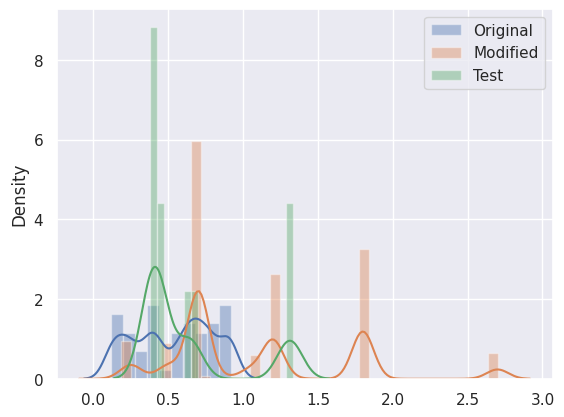

In [21]:
sns.distplot(labels_com_nbp_plus, label = "Original")
sns.distplot(labels, label = "Modified")
sns.distplot(selectedsnr_label_test, label = "Test")

plt.legend()

In [22]:
labels.size

36235

In [23]:
max(labels)

2.7

In [24]:
labels_com_nbp_plus.size

1296

#Regularization

In [ ]:
# ####################################################### REGULARIZATION START ############################################################################

#Validação do alpha para o Lasso com MSE

N = 100
model_Lasso = Lasso(random_state=0, max_iter=1000000, )
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=1)
grid = dict()
grid['alpha'] = arange(0,0.001, 0.00001)

# pesquisa
pesquisa = GridSearchCV(model_Lasso, grid, scoring='neg_mean_squared_error', cv=cv,refit = False)
resultado = pesquisa.fit(features, labels)
cv_res=resultado.cv_results_

#curvas de score
media_score= absolute(cv_res['mean_test_score'])
std_score = absolute(cv_res['std_test_score'])
# print("media_score: \n", media_score)
min_score=min(media_score)
print("min_score: \n", min_score)
index=np.argmin(media_score) # index of the min value
print("index: ",index)
alpha_best_MSE = grid['alpha'][index]
alpha_best_MSE =alpha_best_MSE
print("Alpha = ", alpha_best_MSE)
min_std= std_score[index]

range_alpha = cv_res['param_alpha'].data

# plt.figure(5)                                                         # Cria uma figura de índice 1
# plt.plot(range_alpha, media_score,'b')
# plt.errorbar(range_alpha[index], min_score, yerr=[min_std],fmt='o',mfc='k',ecolor='k',mec='k')        # Acrescenta uma legenda à figura
# plt.title('Lambda\'s search')# Adiciona um título a figura
# plt.annotate(str(round(alpha_best_MSE,5)),xy = (alpha_best_MSE+0.00003,min_score -0.0003))
# plt.ylabel('Error')
# plt.xlabel('Lambda')
# plt.show()
# ####################################################### END OF REGULARIZATION  ############################################################################



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


#Model trainning

In [ ]:
# Abaixo temos os regressores, o treinamento e a predição de cada um que segue a linha a legenda abaixo

LassoDefault = Lasso(alpha = 0.00005, random_state = 0, max_iter=1000000)

print("Started LassoDefault fitting " + datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
LassoDefault.fit(features,labels)
print("Finished LassoDefault fitting " + datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
filename_default = 'Modelos/Regressor_Lasso/comSMOGN_JESS_ace_air_LassoDefault.sav'
pickle.dump(LassoDefault, open(filename_default, 'wb'))
# # # load the model from disk
loaded_model_default = pickle.load(open(filename_default, 'rb'))
results_default = loaded_model_default.predict(selectedsnr_features_test)


tamanho_snr_eval = np.arange(len(selectedsnr_label_test))
tamanho = np.arange(len(labels))

selectedsnr_label_test = np.array(selectedsnr_label_test)
results_3 = np.array(results_default)



#Results

In [ ]:
labels.size

In [ ]:
# #Bota na tela cada métrica de acordo com a legenda dos regressores

print("MSE 3:","%.3f0" % mean_squared_error(results_default,selectedsnr_label_test))
print("MAE 3:", "%.3f0" % mean_absolute_error(results_default,selectedsnr_label_test))
print("corr 3:", round(pearsonr(results_default,selectedsnr_label_test)[0],3))

